We have  100 batches of training images; each with 32 images
We have  18 batches of validation images; each with 32 images
We have  3 batches of testing images; each with 32 images
Single batch torch.Size([32, 3, 224, 224])
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

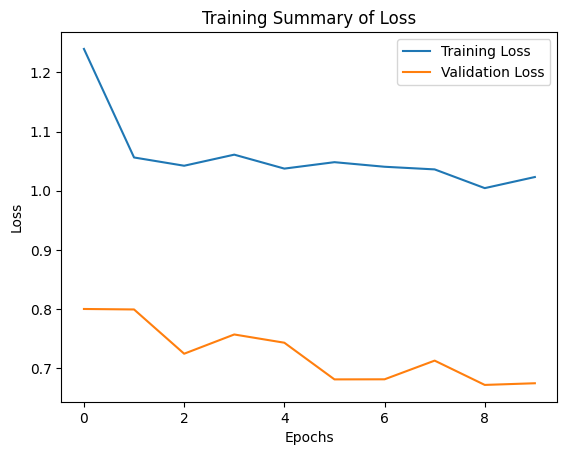

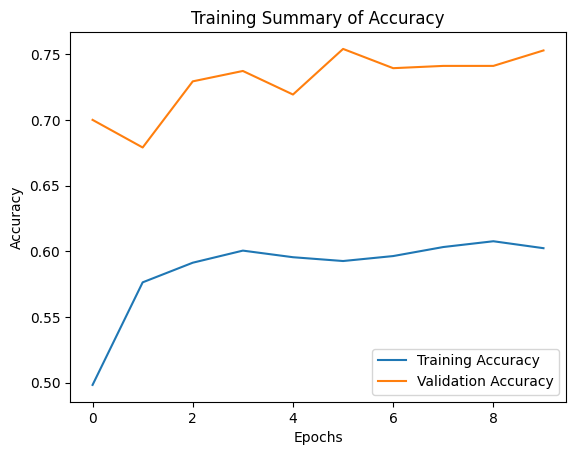

Test Accuracy: 0.7500


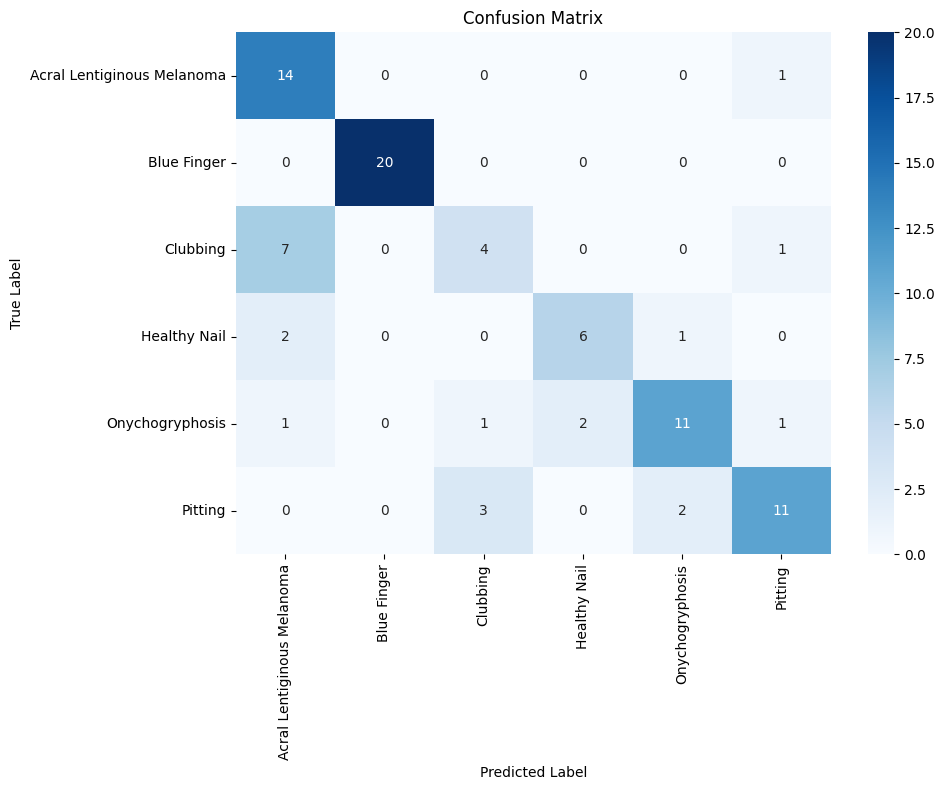

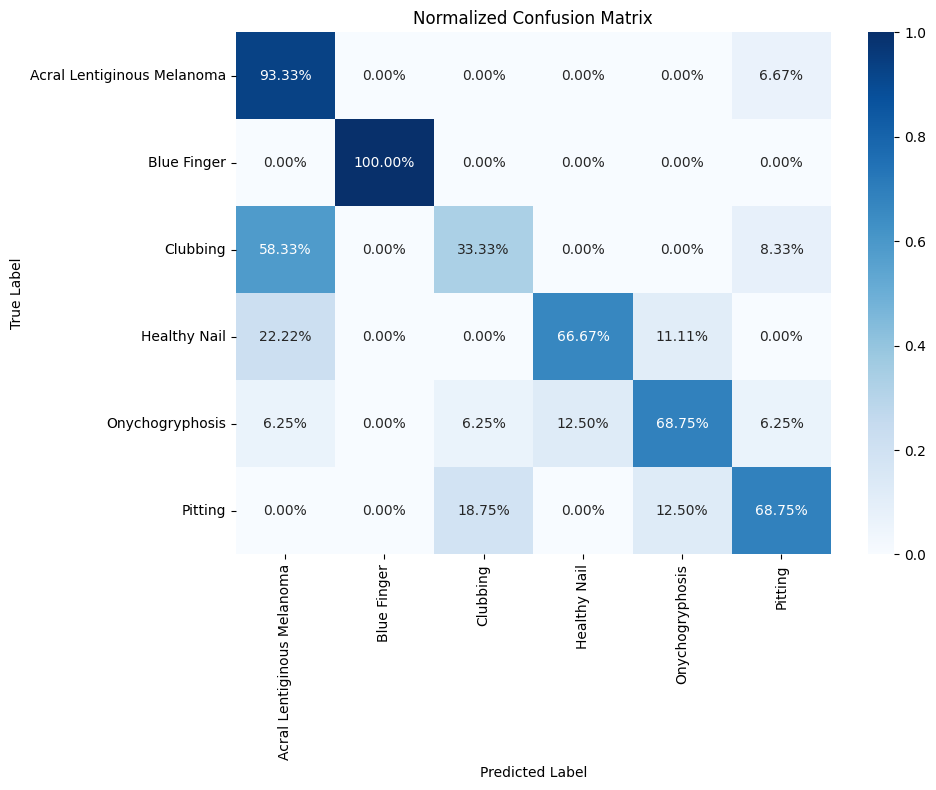

OVERALL ACCURACY: 0.75 (75.0%)

                     Class TP FP FN TN  Precision  Recall  F1-Score  Support
Acral Lentiginous Melanoma 14 10  1 63     0.5833  0.9333    0.7179       15
               Blue Finger 20  0  0 68     1.0000  1.0000    1.0000       20
                  Clubbing  4  4  8 72     0.5000  0.3333    0.4000       12
              Healthy Nail  6  2  3 77     0.7500  0.6667    0.7059        9
           Onychogryphosis 11  3  5 69     0.7857  0.6875    0.7333       16
                   Pitting 11  3  5 69     0.7857  0.6875    0.7333       16
                 Macro Avg                 0.7341  0.7180    0.7151       88
              Weighted Avg                 0.7573  0.7500    0.7430       88


In [7]:
import matplotlib.pyplot as plt
from collections import OrderedDict

from copy import deepcopy
import torch
from torchvision import models  
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

# download the data
data_dir = '/kaggle/input/clean-datasetsplit8515/data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Process with some data transformation, do not change
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}
# This specifies how many images to process per training/validation
batch_size = 32

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder(test_dir,
                                    transform=data_transforms['testing']),
    'validation': datasets.ImageFolder(valid_dir,
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}

# get the length of each dataloaders; with batch size=256, you should have 26 batches of training samples, each with 256 images 
training_len = len(dataloaders['training'])
test_len = len(dataloaders['testing'])
validation_len = len(dataloaders['validation'])
class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')
print('We have ', test_len, 'batches of testing images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)
# Transfer learning with VGG16
model = models.vgg16(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with vgg16
print()
print('Original classifier of VGG16')
print(model.classifier)

# Defining number of hidden units in our fully connected layer
number_of_classes = len(class_to_idx) 
model.classifier[6] = nn.Linear(4096, number_of_classes)
print(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Changed from NLLLoss - this works with raw logits
print_every = 5

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):

    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0

    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Zero gradients first
        optimizer.zero_grad()

        # Forward pass
        logits = model.forward(images)  # Changed variable name for clarity
        loss = criterion(logits, labels)
        
        # Backward pass to compute gradients
        loss.backward()
        
        # Update weights after backward
        optimizer.step()

        # Calculating metrics
        ps = torch.softmax(logits, dim=1)  # Changed from exp since we have raw logits now
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        # Tracking metrics
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

        if batch_idx % print_every == 0:
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())

    # Validation
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)  # Changed variable name
            loss = criterion(logits, labels)
            ps = torch.softmax(logits, dim=1)  # Changed from exp
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()

            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy

    # Save best model
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = model.state_dict()

    # Summary per epoch
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    print('avg validation loss per epoch', validation_loss / validation_len)
    print('avg validation accuracy per epoch',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Load the best model so far
model.load_state_dict(best_model_weights)
model.eval()  # Set to evaluation mode

total_correct = 0
total_samples = 0
predictions = []
label_data = []

with torch.no_grad():  # Disable gradient computation for testing
    for images, labels in dataloaders['testing']:
        images, labels = images.to(device), labels.to(device)
        
        logits = model(images)
        ps = torch.softmax(logits, dim=1)
        
        top_ps, top_class = ps.topk(1, dim=1)
        
        total_correct += (top_class == labels.view(*top_class.shape)).sum().item()
        total_samples += labels.size(0)
        
        predictions.append(top_class)
        label_data.append(labels)

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

predictions = torch.cat(predictions).cpu()
label_data = torch.cat(label_data).cpu()

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as conf_mat
import numpy as np

# Your class labels - replace these with your actual class names
class_names = ['Acral Lentiginous Melanoma', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Onychogryphosis', 'Pitting']

cf = conf_mat(label_data, predictions)

# Plot raw confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
ncf = cf.astype('float') / cf.sum(axis=1, keepdims=True)  # Normalize by row (true labels)
sns.heatmap(ncf, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix as conf_mat

# Your class labels - replace with actual names
class_names = ['Acral Lentiginous Melanoma', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Onychogryphosis', 'Pitting']

cf = conf_mat(label_data, predictions)

# Calculate Overall Accuracy
overall_accuracy = np.trace(cf) / cf.sum()

# Calculate TP, FP, FN, TN for each class
metrics = []
for i, class_name in enumerate(class_names):
    TP = cf[i, i]
    FP = cf[:, i].sum() - TP
    FN = cf[i, :].sum() - TP
    TN = cf.sum() - TP - FP - FN
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    support = cf[i, :].sum()
    
    metrics.append({
        'Class': class_name,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4),
        'Support': support
    })

metrics_df = pd.DataFrame(metrics)

# Calculate Macro Average
macro_avg = {
    'Class': 'Macro Avg',
    'TP': ' ',
    'FP': ' ',
    'FN': ' ',
    'TN': ' ',
    'Precision': round(metrics_df['Precision'].mean(), 4),
    'Recall': round(metrics_df['Recall'].mean(), 4),
    'F1-Score': round(metrics_df['F1-Score'].mean(), 4),
    'Support': metrics_df['Support'].sum()
}

# Calculate Weighted Average
total_support = metrics_df['Support'].sum()
weighted_avg = {
    'Class': 'Weighted Avg',
    'TP': ' ',
    'FP': ' ',
    'FN': ' ',
    'TN': ' ',
    'Precision': round((metrics_df['Precision'] * metrics_df['Support']).sum() / total_support, 4),
    'Recall': round((metrics_df['Recall'] * metrics_df['Support']).sum() / total_support, 4),
    'F1-Score': round((metrics_df['F1-Score'] * metrics_df['Support']).sum() / total_support, 4),
    'Support': total_support
}

# Add averages to dataframe
metrics_df = pd.concat([metrics_df, pd.DataFrame([macro_avg, weighted_avg])], ignore_index=True)

# Print results
print(f"{'='*60}")
print(f"OVERALL ACCURACY: {round(overall_accuracy, 4)} ({round(overall_accuracy*100, 2)}%)")
print(f"{'='*60}\n")
print(metrics_df.to_string(index=False))